In [1]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Dense, InputLayer
from keras.models import Sequential
from xgboost import XGBRegressor
from sklearn import utils, linear_model, ensemble
from sklearn.neighbors import KNeighborsRegressor
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import accuracy_score, roc_auc_score, r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score, LeaveOneOut, KFold, cross_val_predict
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from google.colab import drive
drive.mount('/content/gdrive')
!ls "/content/gdrive/My Drive/Spectra/others"

Mounted at /content/gdrive
'~$sample_others.xlsx'	 result_others.xlsx   sample_others.xlsx


parity plots with bar charts

In [2]:
def scatter_hist_plot(y_true, y_pred, fname=None):
    def scatter_hist(x, y, ax, ax_histx, ax_histy):
        ax.scatter(x, y, color='b', edgecolor='k', alpha=0.65)
        bins = 100
        ax_histx.hist(x, bins=bins, color='darkviolet', edgecolor='k')
        ax_histy.hist(y, bins=bins, orientation='horizontal', color='dodgerblue', edgecolor='k')
        ax_histx.tick_params(labelsize=0)
        ax_histy.tick_params(labelsize=0)

    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.005

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.2]
    rect_histy = [left + width + spacing, bottom, 0.2, height]

    r2_value = r2_score(y_true, y_pred)
    mse_value = mean_squared_error(y_true, y_pred)

    # start with a square Figure
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_axes(rect_scatter)
    ax_histx = fig.add_axes(rect_histx, sharex=ax)
    ax_histy = fig.add_axes(rect_histy, sharey=ax)
    # use the previously defined function
    scatter_hist(y_true, y_pred, ax, ax_histx, ax_histy)
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    ax.text(y_true.max()//3, y_pred.min(), f'$R^2$ = {r2_value:.5f}\nMSE = {mse_value:.5f}', fontsize='x-large')
    ax.set_xlabel('True values',)
    ax.set_ylabel('Predicted values')
    if fname is not None:
        fig.savefig(fname, bbox_inches='tight')

Функция создания шума

In [3]:
def make_noise(data, k):
  data = data.applymap(lambda x: x + (np.random.normal() - 0.5) * k)
  return data

Обрабатываем данные

In [4]:
spec_N = 321
x_params = pd.read_excel(r'/content/gdrive/My Drive/Spectra/others/result_others.xlsx')
y_params = pd.read_excel(r'/content/gdrive/My Drive/Spectra/others/sample_others.xlsx')
y = y_params[['R_Pd-Pd']]
#x = x_params.iloc[:, 50:-200]
x = x_params.iloc[:,:]
X = x.astype('float64')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
fisrt_set = X_train.join(y_train)
second_set = X_test.join(y_test)
all_set = pd.concat([fisrt_set, second_set], sort = False, axis=0)
target = all_set['R_Pd-Pd']
prediction_results = []
x_val = 0
y_val = 0

Feature importance на разных данных, обучено на ExtraTrees



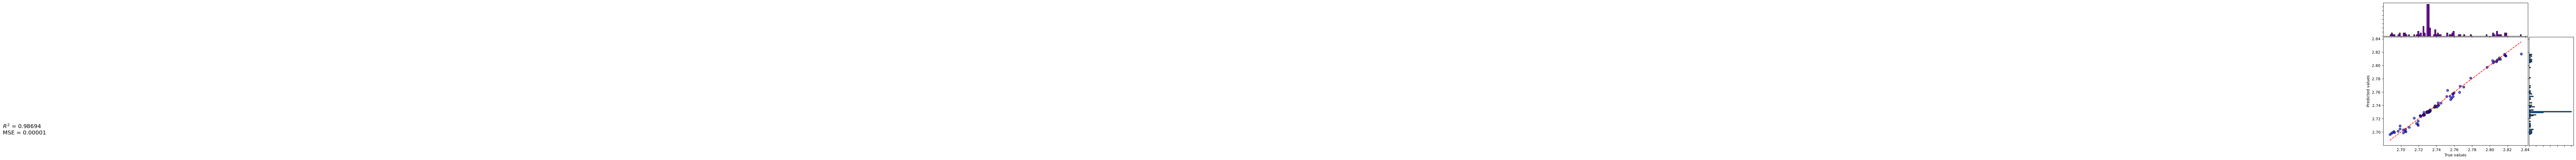

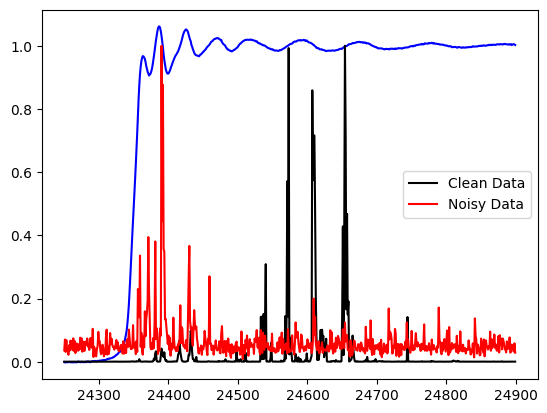

In [5]:
model = ensemble.ExtraTreesRegressor(n_estimators=70, random_state=0)
model.fit(X_train, np.array(y_train.values.tolist()).ravel())

cross_validation = KFold(n_splits=10, shuffle=True, random_state=0)
model_prediction = cross_val_predict(model, X_test, np.array(y_test.values.tolist()).ravel(), cv=cross_validation)

energy = []

for i in range(len(X_train.columns)):
    energy.append(float(X_train.columns[i]))
energy = np.array(energy)

rms = scatter_hist_plot(np.array(y_test.values.tolist()).ravel(), model_prediction)
plt.show()

mse_value = mean_squared_error(np.array(y_test.values.tolist()).ravel(), model_prediction)
rmse_value = mean_squared_error(np.array(y_test.values.tolist()).ravel(), model_prediction, squared=False)
r2_value = r2_score(np.array(y_test.values.tolist()).ravel(), model_prediction)

prediction_results.append(('ExtTr', rmse_value, r2_value))

X = X_train.loc[:, :].values
plt.plot(energy, X[200], 'b')

importance_clean = model.feature_importances_
ind_clean = np.argmax(importance_clean)
plt.plot(energy, importance_clean / importance_clean.max(), 'k-', label='Clean Data')

X_noisy = make_noise(X_train, 0.1)  # Add noise to the features with noise level 0.1
model.fit(X_noisy, np.array(y_train.values.tolist()).ravel())

importance_noisy = model.feature_importances_
ind_noisy = np.argmax(importance_noisy)
plt.plot(energy, importance_noisy / importance_noisy.max(), 'r-', label='Noisy Data')

plt.legend()
plt.show()

R2-score и RMSE с разным уровнем зашумления

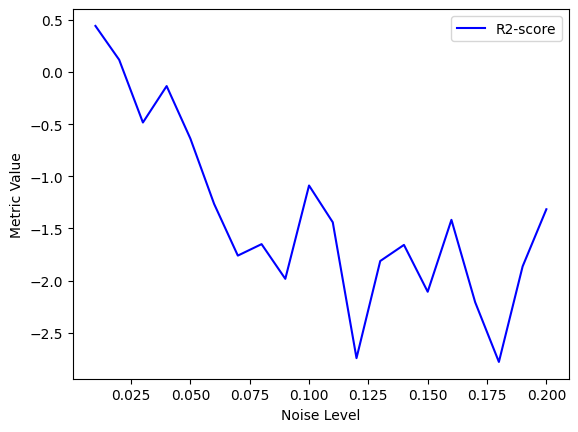

In [6]:
noises = np.arange(0.01, 0.21, 0.01)  # Значения шума от 0.01 до 0.2 с шагом 0.01
r2_scores = []
mse_values = []

for noise in noises:
    X_train_noisy = make_noise(X_train, noise)
    X_test_noisy = make_noise(X_test, noise)
    # y_noisy = make_noise(y_train, noise)

    model = ensemble.ExtraTreesRegressor(n_estimators=70, random_state=0)
    model.fit(X_train_noisy, np.array(y_train.values.tolist()).ravel())

    cross_validation = KFold(n_splits=10, shuffle=True, random_state=0)
    r2_values = cross_val_score(model, X_test_noisy, np.array(y_test.values.tolist()).ravel(), cv=cross_validation, scoring='r2')
    # print(r2_values)
    r2_mean = np.mean(r2_values)
    mse_value = mean_squared_error(y_test, model.predict(X_test_noisy))

    r2_scores.append(r2_mean)
    mse_values.append(mse_value)

plt.plot(noises, r2_scores, 'b-', label='R2-score')
# plt.plot(noises, mse_values, 'r-', label='MSE')
plt.xlabel('Noise Level')
plt.ylabel('Metric Value')
plt.legend()
plt.show()

In [7]:
r2_scores

[0.4420469794432204,
 0.11720550221247099,
 -0.4843032184525364,
 -0.13482460621967693,
 -0.6385704457110519,
 -1.2648773512116294,
 -1.76077432698056,
 -1.6508221751090069,
 -1.983596011693836,
 -1.0885555621377252,
 -1.4412927835697993,
 -2.744336081977194,
 -1.8128084008663337,
 -1.65814644221538,
 -2.1075336447756423,
 -1.4178616407638611,
 -2.2076755494886884,
 -2.780514125645044,
 -1.8644882530425453,
 -1.3162937265610053]

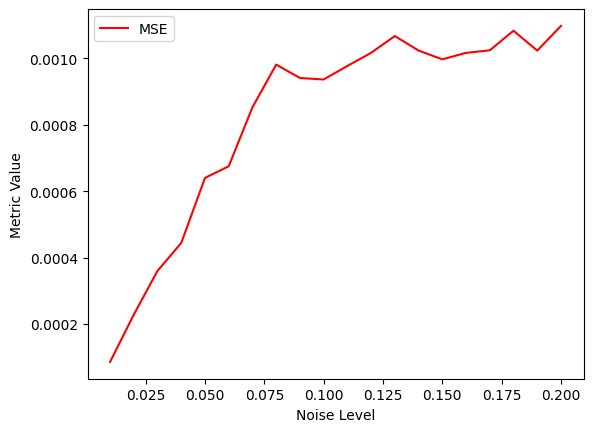

In [8]:
plt.plot(noises, mse_values, 'r-', label='MSE')
plt.xlabel('Noise Level')
plt.ylabel('Metric Value')
plt.legend()
plt.show()

Обучение на разных частях выборки

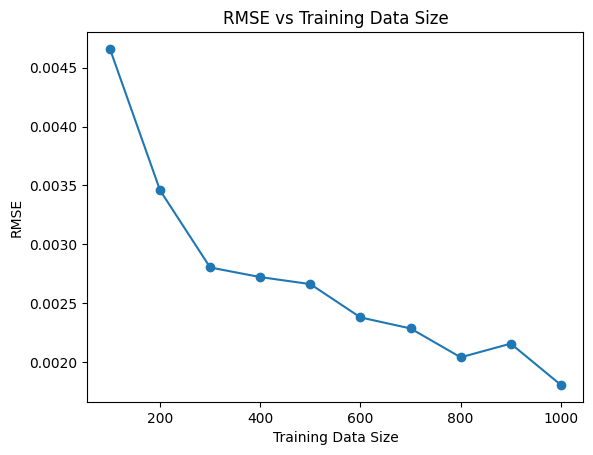

In [9]:
#r2_arr = []
#mse_arr = []
#range_arr = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
#for i in range_arr:
#  model = ensemble.ExtraTreesRegressor(n_estimators= 70, random_state=0)
#  model.fit(X_train.iloc[:i, :], np.array(y_train.iloc[:i, :]).ravel())
#  prediction = model.predict(X_test)
#  r2_arr.append(r2_score(np.array(y_test.values.tolist()).ravel(), prediction))
#  mse_arr.append(mean_squared_error(np.array(y_test.values.tolist()).ravel(), prediction))

#plt.plot(range_arr, r2_arr, '-o')
#plt.show()

#plt.plot(range_arr, mse_arr, '-o')
#plt.show()

range_arr = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
rmse_arr = []

for i in range_arr:
    model = ensemble.ExtraTreesRegressor(n_estimators=70, random_state=0)
    model.fit(X_train.iloc[:i, :], np.array(y_train.iloc[:i, :]).ravel())
    prediction = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(np.array(y_test.values.tolist()).ravel(), prediction))
    rmse_arr.append(rmse)

plt.plot(range_arr, rmse_arr, '-o')
plt.xlabel('Training Data Size')
plt.ylabel('RMSE')
plt.title('RMSE vs Training Data Size')
plt.show()


Деревья решений

accuracy: [0.99945452 0.99956757 0.99933171 0.99881706 0.99949078 0.99959073
 0.99854488 0.99902445 0.99977708 0.99949116]
mean accuracy: 1.00


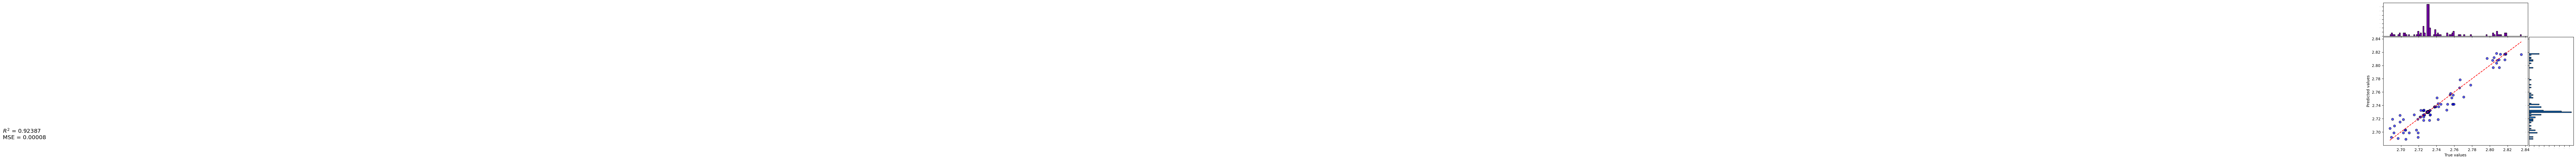

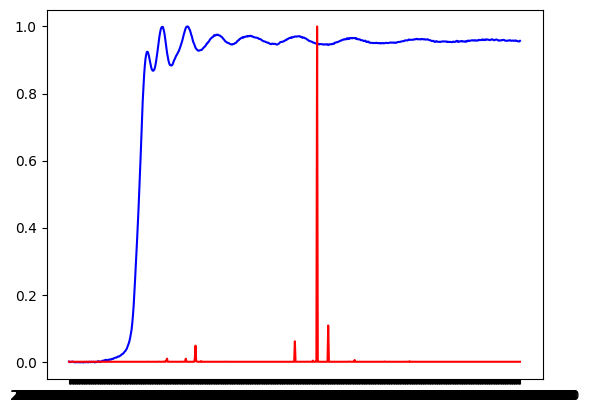

In [10]:
model = DecisionTreeRegressor()
model.fit(X_train, np.array(y_train.values.tolist()).ravel())
#prediction = model.predict(X_test)
cross_validation = KFold(n_splits=10, shuffle=True, random_state=0)
model_prediction = cross_val_predict(model, X_test, np.array(y_test.values.tolist()).ravel(), cv=cross_validation)
scores = cross_val_score(model, all_set, target, cv = 10)
print("accuracy: {}".format(scores))
print("mean accuracy: {:.2f}".format(scores.mean()))
rms = scatter_hist_plot(np.array(y_test.values.tolist()).ravel(), model_prediction)
mse_value = mean_squared_error(np.array(y_test.values.tolist()).ravel(), model_prediction)
rmse_value = mean_squared_error(np.array(y_test.values.tolist()).ravel(), model_prediction, squared=False)
r2_value = r2_score(np.array(y_test.values.tolist()).ravel(), model_prediction)

prediction_results.append(('DecTr', rmse_value, r2_value))
plt.show()

plt.plot(X_train.columns, X[0]/X[0].max(), 'b')
importance = model.feature_importances_
ind = np.argmax(importance)
plt.plot(X_train.columns, importance/importance.max(), 'r-')
plt.show()

XGBoost

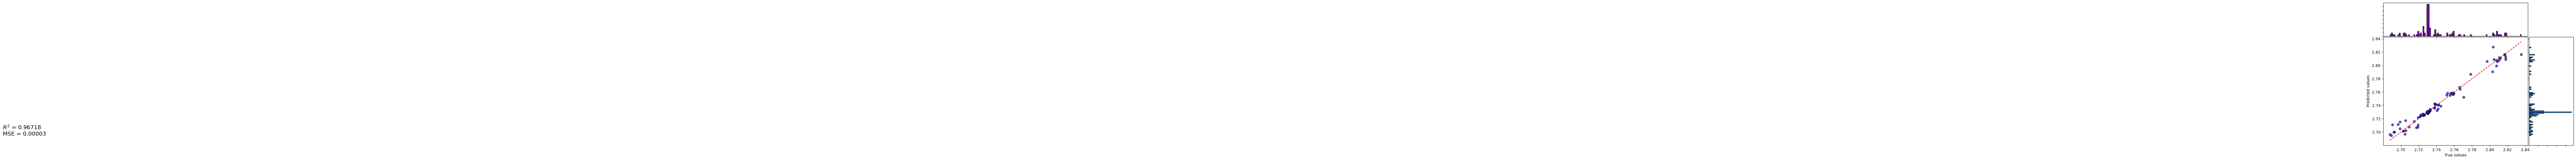

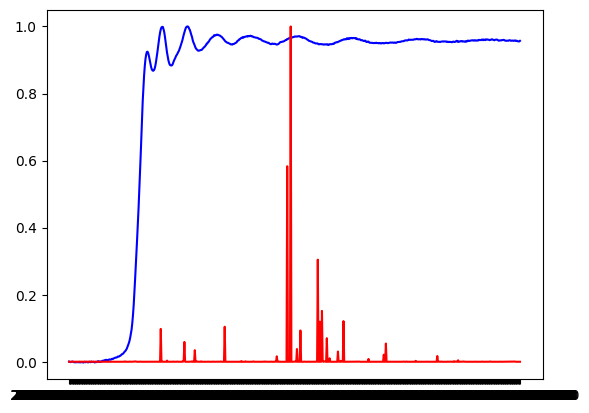

In [11]:
model = XGBRegressor()
model.fit(X_train, np.array(y_train.values.tolist()).ravel())
#prediction = model.predict(X_test)
cross_validation = KFold(n_splits=10, shuffle=True, random_state=0)
model_prediction = cross_val_predict(model, X_test, np.array(y_test.values.tolist()).ravel(), cv=cross_validation)
rms = scatter_hist_plot(np.array(y_test.values.tolist()).ravel(), model_prediction)
mse_value = mean_squared_error(np.array(y_test.values.tolist()).ravel(), model_prediction)
rmse_value = mean_squared_error(np.array(y_test.values.tolist()).ravel(), model_prediction, squared=False)
r2_value = r2_score(np.array(y_test.values.tolist()).ravel(), model_prediction)

prediction_results.append(('XGBoost', rmse_value, r2_value))
plt.show()


plt.plot(X_train.columns, X[0]/X[0].max(), 'b')
importance = model.feature_importances_
ind = np.argmax(importance)
plt.plot(X_train.columns, importance/importance.max(), 'r-')

Алгоритм случайного леса

In [ ]:
model = RandomForestRegressor()
model.fit(X_train, np.array(y_train.values.tolist()).ravel())
#prediction = model.predict(X_test)
cross_validation = KFold(n_splits=10, shuffle=True, random_state=0)
model_prediction = cross_val_predict(model, X_test, np.array(y_test.values.tolist()).ravel(), cv=cross_validation)
rms = scatter_hist_plot(np.array(y_test.values.tolist()).ravel(), model_prediction)
mse_value = mean_squared_error(np.array(y_test.values.tolist()).ravel(), model_prediction)
rmse_value = mean_squared_error(np.array(y_test.values.tolist()).ravel(), model_prediction, squared=False)
r2_value = r2_score(np.array(y_test.values.tolist()).ravel(), model_prediction)

prediction_results.append(('RandF', rmse_value, r2_value))
plt.show()


plt.plot(X_train.columns, X[0]/X[0].max(), 'b')
importance = model.feature_importances_
ind = np.argmax(importance)
plt.plot(X_train.columns, importance/importance.max(), 'r-')



Метод регрессии лассо LASSO


In [ ]:
model = LassoCV(cv=2, random_state=0)
model.fit(X_train, np.array(y_train.values.tolist()).ravel())
#prediction = model.predict(X_test)
cross_validation = KFold(n_splits=10, shuffle=True, random_state=0)
model_prediction = cross_val_predict(model, X_test, np.array(y_test.values.tolist()).ravel(), cv=cross_validation)
scores = cross_val_score(model, all_set, target, cv = 10)
print("accuracy: {}".format(scores))
print("mean accuracy: {:.2f}".format(scores.mean()))
rms = scatter_hist_plot(np.array(y_test.values.tolist()).ravel(), model_prediction)
mse_value = mean_squared_error(np.array(y_test.values.tolist()).ravel(), model_prediction)
rmse_value = mean_squared_error(np.array(y_test.values.tolist()).ravel(), model_prediction, squared=False)
r2_value = r2_score(np.array(y_test.values.tolist()).ravel(), model_prediction)

prediction_results.append(('Lasso', rmse_value, r2_value))




Гребневая регрессия Ридж-регрессия


In [ ]:
model = linear_model.Ridge()
model.fit(X_train, np.array(y_train.values.tolist()).ravel())
#prediction = model.predict(X_test)
cross_validation = KFold(n_splits=10, shuffle=True, random_state=0)
model_prediction = cross_val_predict(model, X_test, np.array(y_test.values.tolist()).ravel(), cv=cross_validation)
scores = cross_val_score(model, all_set, target, cv = 10)
print("accuracy: {}".format(scores))
print("mean accuracy: {:.2f}".format(scores.mean()))
rms = scatter_hist_plot(np.array(y_test.values.tolist()).ravel(), model_prediction)
mse_value = mean_squared_error(np.array(y_test.values.tolist()).ravel(), model_prediction)
rmse_value = mean_squared_error(np.array(y_test.values.tolist()).ravel(), model_prediction, squared=False)
r2_value = r2_score(np.array(y_test.values.tolist()).ravel(), model_prediction)

prediction_results.append(('Ridge', rmse_value, r2_value))



ElasticNet


In [ ]:
model = ElasticNetCV()
model.fit(X_train, np.array(y_train.values.tolist()).ravel())
#prediction = model.predict(X_test)
cross_validation = KFold(n_splits=10, shuffle=True, random_state=0)
model_prediction = cross_val_predict(model, X_test, np.array(y_test.values.tolist()).ravel(), cv=cross_validation)
scores = cross_val_score(model, all_set, target, cv = 10)
print("accuracy: {}".format(scores))
print("mean accuracy: {:.2f}".format(scores.mean()))
rms = scatter_hist_plot(np.array(y_test.values.tolist()).ravel(), model_prediction)
mse_value = mean_squared_error(np.array(y_test.values.tolist()).ravel(), model_prediction)
rmse_value = mean_squared_error(np.array(y_test.values.tolist()).ravel(), model_prediction, squared=False)
r2_value = r2_score(np.array(y_test.values.tolist()).ravel(), model_prediction)

prediction_results.append(('ElNet', rmse_value, r2_value))

Метод ближайших соседей

In [ ]:
model = neighbors.KNeighborsRegressor(n_neighbors=50)
#knn.fit(x.reshape(-1,1),y)
#KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
#          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
#          weights='uniform')
model.fit(X_train, np.array(y_train.values.tolist()).ravel())
#prediction = model.predict(X_test)
cross_validation = KFold(n_splits=10, shuffle=True, random_state=0)
model_prediction = cross_val_predict(model, X_test, np.array(y_test.values.tolist()).ravel(), cv=cross_validation)
prediction = model.predict(X_test)
scores = cross_val_score(model, all_set, target, cv = 10)
print("accuracy: {}".format(scores))
print("mean accuracy: {:.2f}".format(scores.mean()))
rms = scatter_hist_plot(np.array(y_test.values.tolist()).ravel(), model_prediction)
mse_value = mean_squared_error(np.array(y_test.values.tolist()).ravel(), model_prediction)
rmse_value = mean_squared_error(np.array(y_test.values.tolist()).ravel(), model_prediction, squared=False)
r2_value = r2_score(np.array(y_test.values.tolist()).ravel(), model_prediction)

prediction_results.append(('KNN', rmse_value, r2_value))


Сравнение методов

In [ ]:
#prediction_results.sort(key = lambda x: x[1])
#x_val = [x[0] for x in prediction_results]
#y_val = [x[1] for x in prediction_results]

#plt.plot(x_val,y_val)
#plt.plot(x_val,y_val,'or')
#plt.xticks(rotation=90)
#plt.show()

#print(x_val)
#print(y_val)

import matplotlib.pyplot as plt

prediction_results.sort(key=lambda x: x[1])
x_val = [x[0] for x in prediction_results]
y_val_rmse = [x[1] for x in prediction_results]
y_val_r2 = [x[2] for x in prediction_results]

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.plot(x_val, y_val_rmse, color=color)
ax1.set_xlabel('Data Points')
ax1.set_ylabel('RMSE', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.plot(x_val, y_val_r2, color=color)
ax2.set_ylabel('R2-score', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('RMSE and R2-score vs Data Points')
plt.xticks(rotation=90)
plt.show()

print(x_val)
print(y_val_rmse)
print(y_val_r2)
